In [1]:
import json
import h5py
import tqdm
import datetime
import time
import pandas as pd
import numpy as np

import importlib
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
sys.path.insert(0, '/cndd2/fangming/projects/SingleCellRoutines')

import __init__plots
importlib.reload(__init__plots)
from __init__plots import *

import snmcseq_utils
importlib.reload(snmcseq_utils)

import utils
importlib.reload(utils)

<module 'utils' from '/cndd2/fangming/projects/SingleCellRoutines/utils.py'>

In [2]:
today = datetime.date.today()
figures = '../figures/{}_{{}}'.format(today)
figures

'../figures/2021-05-28_{}'

# read in processed data

In [3]:
# palette as json
file = '../data/palette.json'
with open(file, 'r') as f:
    palette = json.load(f)
palette

{'Slice1_Replicate1': [0.19215686274509805,
  0.5098039215686274,
  0.7411764705882353],
 'Slice1_Replicate2': [0.4196078431372549,
  0.6823529411764706,
  0.8392156862745098],
 'Slice1_Replicate3': [0.6196078431372549,
  0.792156862745098,
  0.8823529411764706],
 'Slice2_Replicate1': [0.9019607843137255,
  0.3333333333333333,
  0.050980392156862744],
 'Slice2_Replicate2': [0.9921568627450981,
  0.5529411764705883,
  0.23529411764705882],
 'Slice2_Replicate3': [0.9921568627450981,
  0.6823529411764706,
  0.4196078431372549],
 'Slice3_Replicate1': [0.19215686274509805,
  0.6392156862745098,
  0.32941176470588235],
 'Slice3_Replicate2': [0.4549019607843137,
  0.7686274509803922,
  0.4627450980392157],
 'Slice3_Replicate3': [0.6313725490196078,
  0.8509803921568627,
  0.6078431372549019]}

In [4]:
!ls ../data/*.tsv.gz

../data/clustering_embedding_S1R1_S1R2_S1R3_S2R1_S2R2_S2R3_S3R1_S3R2_S3R3_2021-05-22.tsv.gz
../data/clustering_embedding_S1R2_2021-05-22.tsv.gz
../data/clustering_embedding_S2R1_2021-05-22.tsv.gz
../data/clustering_embedding_S2R1_S1R2_2021-05-22.tsv.gz
../data/clustering_embedding_Slice1_Replicate2_2021-05-18.tsv.gz
../data/clustering_embedding_Slice2_Replicate1_2021-05-15.tsv.gz


In [5]:
f = '../data/clustering_embedding_S1R1_S1R2_S1R3_S2R1_S2R2_S2R3_S3R1_S3R2_S3R3_2021-05-22.tsv.gz'
clsts = pd.read_csv(f, sep='\t').set_index('cell')
print(clsts.shape)
clsts.head()

(692682, 4)


cluster    umap_1     umap_2  \
cell                                                                   
110883424764611924400221639916314253469     C14  1.417047   9.138863   
135188247894899244046039873973964001182     C14  1.260269   8.663673   
164766962839370328502017156371562646881     C14 -0.179721  10.929612   
165747897693809971960756442245389760838     C14  0.770016  10.161936   
260943245639750847364278545493286724628     C14  0.422456  10.411513   

                                                    sample  
cell                                                        
110883424764611924400221639916314253469  Slice1_Replicate1  
135188247894899244046039873973964001182  Slice1_Replicate1  
164766962839370328502017156371562646881  Slice1_Replicate1  
165747897693809971960756442245389760838  Slice1_Replicate1  
260943245639750847364278545493286724628  Slice1_Replicate1

In [6]:
input = '../data/processed_vizgen_merfish_may22_2021.hdf5'
samples = [
    'Slice1_Replicate1',
    'Slice1_Replicate2',
    'Slice1_Replicate3',
    
    'Slice2_Replicate1',
    'Slice2_Replicate2',
    'Slice2_Replicate3',
    
    'Slice3_Replicate1',
    'Slice3_Replicate2',
    'Slice3_Replicate3',
]

samples_shortname = "_".join([
    sample.replace('Slice', 'S').replace('_Replicate', 'R')
    for sample in samples
])

for sample in samples:
    gmat = []
    meta = []
    for sample in samples:
        _gmat = pd.read_hdf(input, 'mat_'+sample)
        gmat.append(_gmat)
        _meta = pd.read_hdf(input, 'meta_'+sample)
        _meta['sample'] = sample 
        meta.append(_meta)
gmat = pd.concat(gmat)
meta = pd.concat(meta)


In [7]:
# informations
thedata = clsts.drop('sample', axis=1).join(meta) #.join(clsts)
genes = gmat.columns
print(len(genes), gmat.shape, meta.shape)

483 (692682, 483) (692682, 13)


# plotting functions

In [8]:
def plot_umap_routine(ax, x, y, hue, toplot, palette=None, legend=False, title='', fontsize=12):
    """
    """
    sns.scatterplot(x=x, y=y, hue=hue, data=toplot, 
                    hue_order=np.sort(toplot[hue].unique()),
                    palette=palette,
                    s=2, 
                    alpha=0.9,
                    linewidth=0, 
                    rasterized=True, 
                    legend=legend, 
                    ax=ax,
                   )
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title)

    # arrows
    ax.arrow(0.01, 0.01, 0, 0.1,
             transform=ax.transAxes,
             head_width=0.01, head_length=0.01, fc='k', ec='k')
    ax.arrow(0.01, 0.01, 0.1, 0,
             transform=ax.transAxes,
             head_width=0.01, head_length=0.01, fc='k', ec='k')
    ax.text(0.01, 0, 'UMAP', 
            transform=ax.transAxes,
            va='top', ha='left', fontsize=fontsize)
    # # arrows
    return 

def plot_spatial_routine(ax, x, y, hue, toplot, palette=None, legend=False, title='', fontsize=12):
    """
    """
    sns.scatterplot(x=x, y=y, hue=hue, data=toplot, 
                    hue_order=np.sort(toplot[hue].unique()),
                    palette=palette,
                    s=2, 
                    alpha=0.9,
                    linewidth=0, 
                    rasterized=True, 
                    legend=legend, 
                    ax=ax,
                   )
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title)
    
    # arrows
    ax.arrow(0.01, 0.01, 0, 0.1,
             transform=ax.transAxes,
             head_width=0.01, head_length=0.01, fc='k', ec='k')
    ax.arrow(0.01, 0.01, 0.1, 0,
             transform=ax.transAxes,
             head_width=0.01, head_length=0.01, fc='k', ec='k')
    ax.text(0.01, 0, 'In situ', 
            transform=ax.transAxes,
            va='top', ha='left', fontsize=fontsize)
    # end arrows
    
    # scale bar
    length = 1000
    left = 3500
    length, left = 1000, 3500 
    ax.hlines(0.01, left, left+length, color='k', linewidth=3, 
              transform=ax.get_xaxis_transform())
    ax.text(left+length, 0, '1 mm', 
            va='top', ha='right', 
            transform=ax.get_xaxis_transform(),
            fontsize=fontsize)
    # end scale bar
    return



In [9]:
def plot_continuous_umap_routine(
    ax, x, y, hue, toplot, vmaxp=99, palette=None, title='', fontsize=12, pth=50):
    """
    # colorbar
    norm = plt.Normalize(0, vmaxp)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm,)
    fig.colorbar(sm, cax=cax, label='Percentile', ticks=[0, vmaxp])
    """
    vmin, vmax = 0, np.percentile(toplot[hue], vmaxp)
    cmap = sns.cubehelix_palette(as_cmap=True)
    pth = np.percentile(toplot[hue], pth)
    
    sns.scatterplot(x=x, y=y, hue=hue, data=toplot, 
                    s=1, 
                    alpha=0.3,
                    linewidth=0, 
                    legend=False, 
                    rasterized=True, 
                    vmin=vmin, 
                    vmax=vmax,
                    palette=cmap,
                    ax=ax,
                   )
    g = sns.scatterplot(x=x, y=y, hue=hue, data=toplot[toplot[hue]>pth], 
                        s=3, 
                        alpha=1,
                        linewidth=0, 
                        legend=False,
                        rasterized=True, 
                        vmin=vmin, 
                        vmax=vmax,
                        palette=cmap,
                        ax=ax,
                       )
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title)

    # arrows
    ax.arrow(0.01, 0.01, 0, 0.1,
             transform=ax.transAxes,
             head_width=0.01, head_length=0.01, fc='k', ec='k')
    ax.arrow(0.01, 0.01, 0.1, 0,
             transform=ax.transAxes,
             head_width=0.01, head_length=0.01, fc='k', ec='k')
    ax.text(0.01, 0, 'UMAP', 
            transform=ax.transAxes,
            va='top', ha='left', fontsize=fontsize)
    # # arrows
    return 

def plot_continuous_spatial_routine(
    ax, x, y, hue, toplot, vmaxp=99, palette=None, title='', fontsize=12):
    """
    # colorbar
    norm = plt.Normalize(0, vmaxp)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm,)
    fig.colorbar(sm, cax=cax, label='Percentile', ticks=[0, vmaxp])
    """
    vmin, vmax = 0, np.percentile(toplot[hue], vmaxp)
    cmap = sns.cubehelix_palette(as_cmap=True)
    
    sns.scatterplot(x=x, y=y, hue=hue, data=toplot, 
                    s=1, 
                    alpha=0.3,
                    linewidth=0, 
                    legend=False, 
                    rasterized=True, 
                    vmin=vmin, 
                    vmax=vmax,
                    palette=cmap,
                    ax=ax,
                   )
    g = sns.scatterplot(x=x, y=y, hue=hue, data=toplot[toplot[hue]>0], 
                        s=3, 
                        alpha=1,
                        linewidth=0, 
                        legend=False,
                        rasterized=True, 
                        vmin=vmin, 
                        vmax=vmax,
                        palette=cmap,
                        ax=ax,
                       )
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title)
    
    # arrows
    ax.arrow(0.01, 0.01, 0, 0.1,
             transform=ax.transAxes,
             head_width=0.01, head_length=0.01, fc='k', ec='k')
    ax.arrow(0.01, 0.01, 0.1, 0,
             transform=ax.transAxes,
             head_width=0.01, head_length=0.01, fc='k', ec='k')
    ax.text(0.01, 0, 'In situ', 
            transform=ax.transAxes,
            va='top', ha='left', fontsize=fontsize)
    # end arrows
    
    # scale bar
    length = 1000
    left = 3500
    length, left = 1000, 3500 
    ax.hlines(0.01, left, left+length, color='k', linewidth=3, 
              transform=ax.get_xaxis_transform())
    ax.text(left+length, 0, '1 mm', 
            va='top', ha='right', 
            transform=ax.get_xaxis_transform(),
            fontsize=fontsize)
    # end scale bar
    return

In [10]:
# unify cluster palette 
# cmap chage
uniq_clsts = np.sort(clsts['cluster'].unique())
colors = sns.color_palette('husl', len(uniq_clsts))
palette_clsts = {clst: color for clst, color in zip(uniq_clsts, colors)}

../figures/2021-05-28_in_situ_by_clusters_Slice3_Replicate3.pdf
../figures/2021-05-28_in_situ_by_clusters_Slice3_Replicate3.png


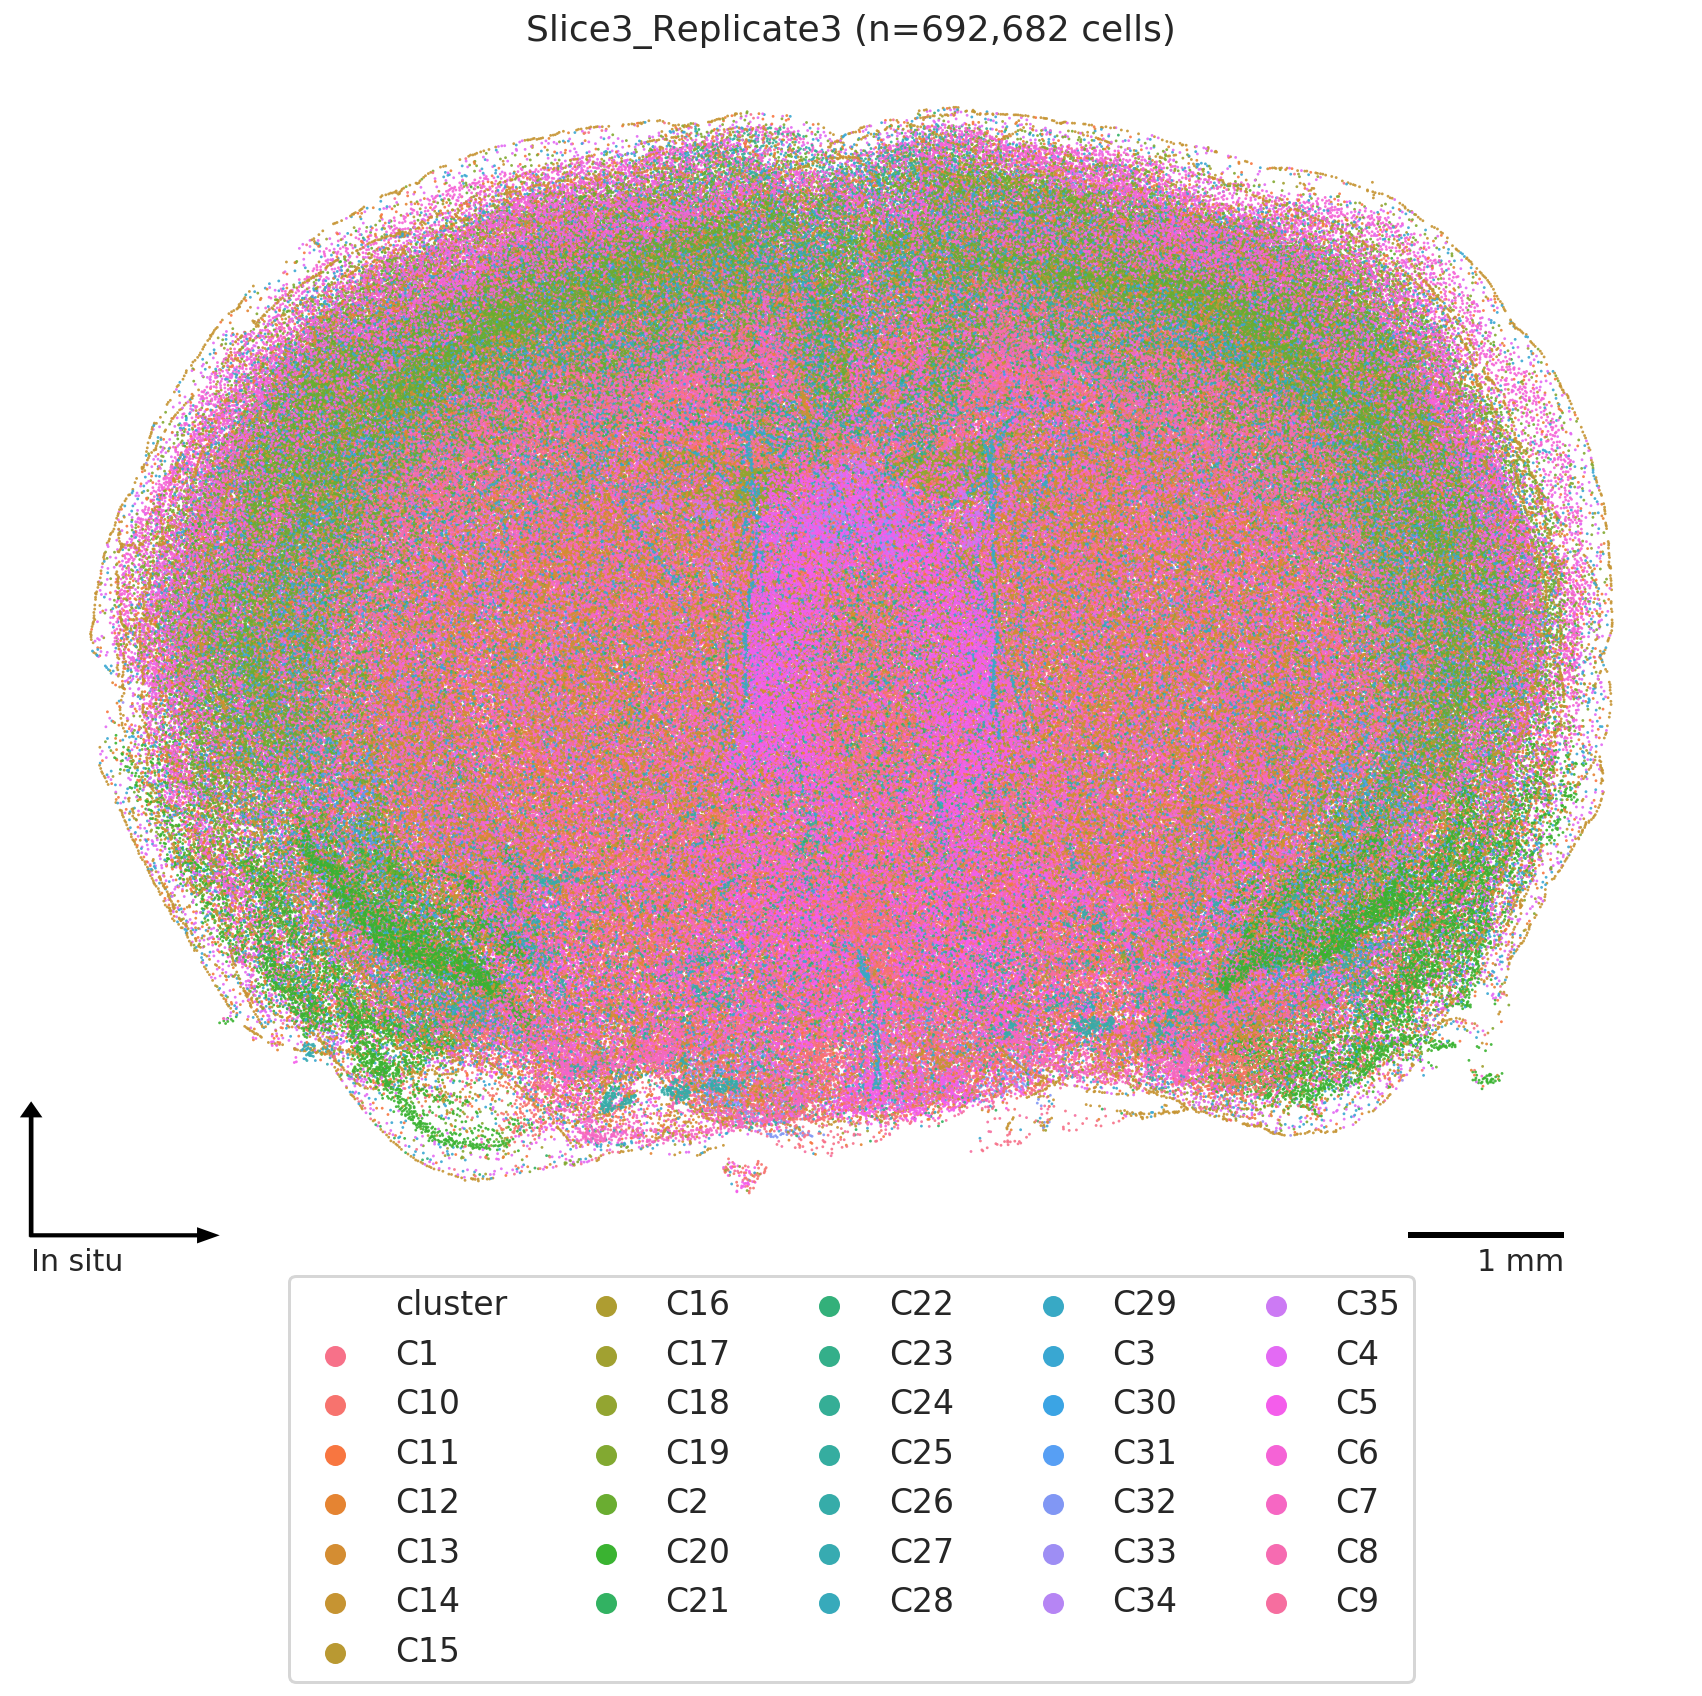

In [11]:
output1 = figures.format('in_situ_by_clusters_{}.pdf'.format(sample))
output2 = figures.format('in_situ_by_clusters_{}.png'.format(sample))

x, y, hue = 'x', 'y', 'cluster'
toplot = thedata
title = '{} (n={:,} cells)'.format(sample, len(toplot))
legend = 'full'
palette = palette_clsts
figsize = (15, 12)
fontsize = 15

fig, ax = plt.subplots(figsize=figsize)
plot_spatial_routine(ax, x, y, hue, toplot, palette, legend=legend, title=title, fontsize=fontsize)
ax.legend(bbox_to_anchor=(0.5,-0.01), loc='upper center', ncol=5)

for output in [output1, output2]:
    print(output)
    snmcseq_utils.savefig(fig, output)
    
plt.show()

../figures/2021-05-28_umap_by_clusters_Slice3_Replicate3.pdf
../figures/2021-05-28_umap_by_clusters_Slice3_Replicate3.png


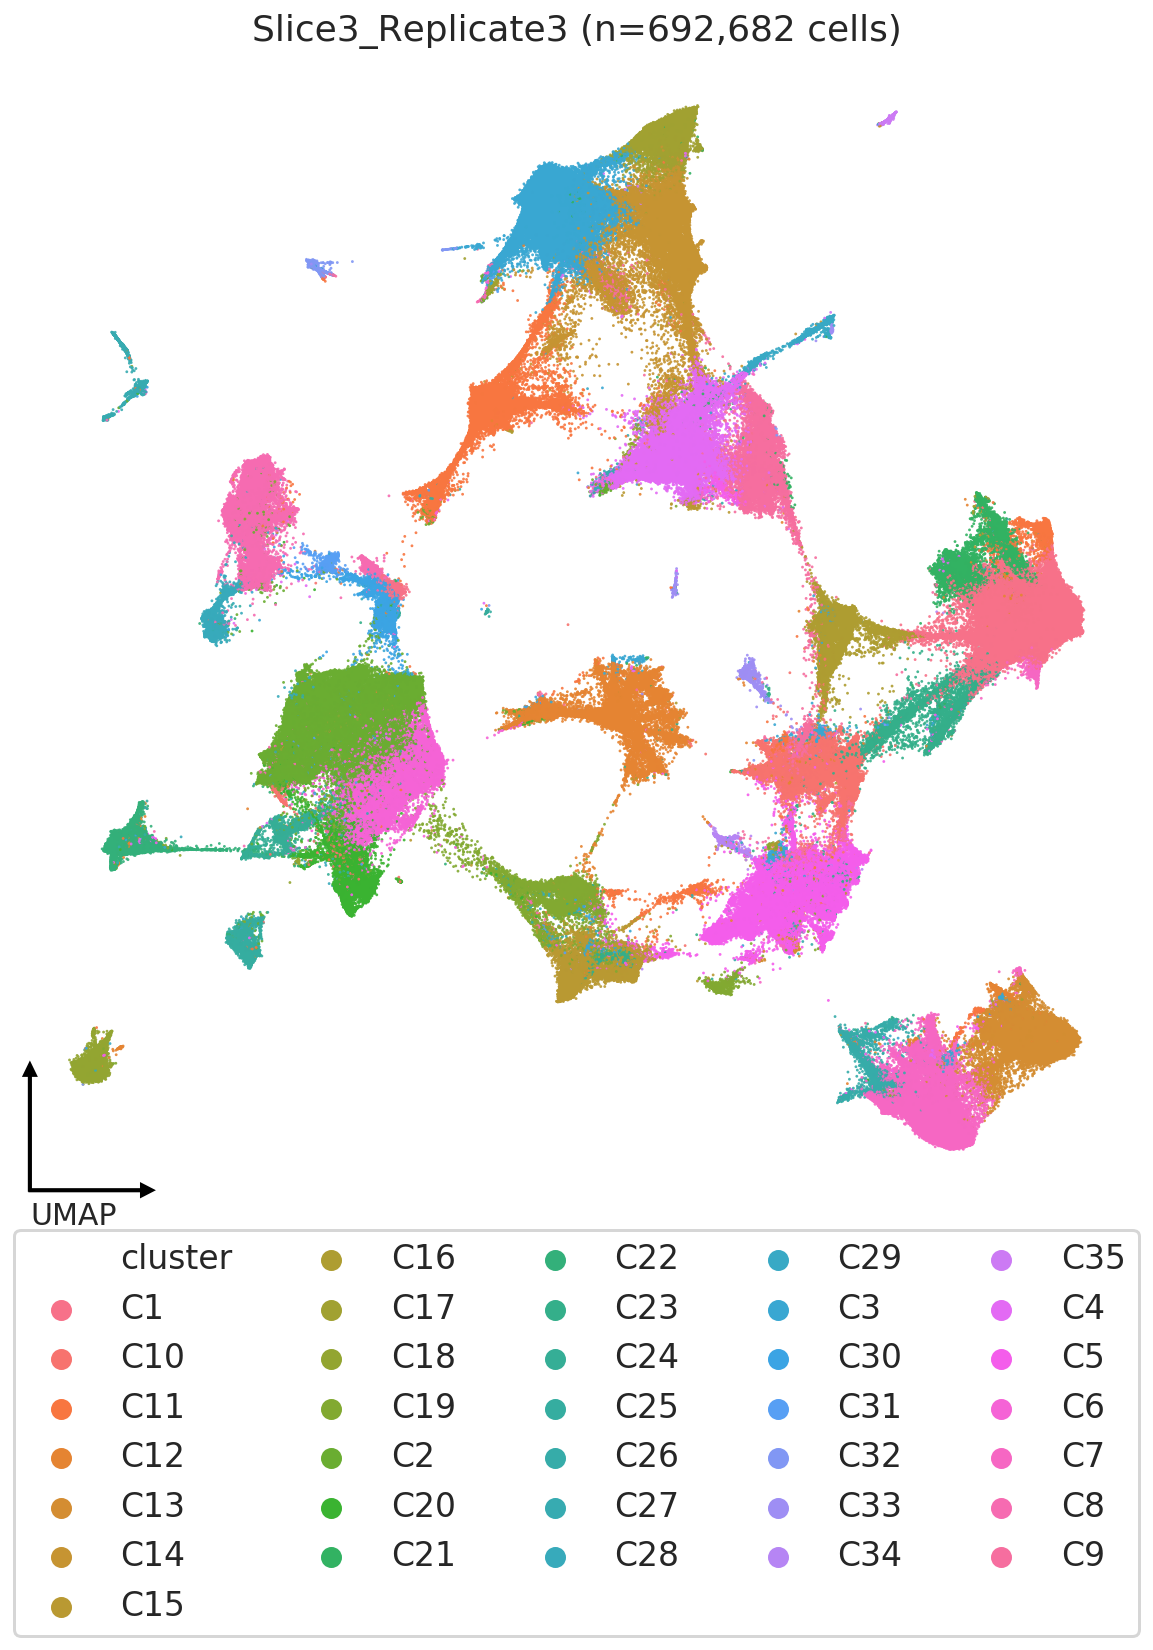

In [12]:
output1 = figures.format('umap_by_clusters_{}.pdf'.format(sample))
output2 = figures.format('umap_by_clusters_{}.png'.format(sample))

x, y, hue = 'umap_1', 'umap_2', 'cluster'
toplot = thedata
title = '{} (n={:,} cells)'.format(sample, len(toplot))
legend = 'full'
palette = palette_clsts
figsize = (10, 12)
fontsize = 15

fig, ax = plt.subplots(figsize=figsize)
plot_umap_routine(ax, x, y, hue, toplot, palette, legend=legend, title=title, fontsize=fontsize)
ax.legend(bbox_to_anchor=(0.5,-0.01), loc='upper center', ncol=5)

for output in [output1, output2]:
    print(output)
    snmcseq_utils.savefig(fig, output)
plt.show()

## Try datashader

In [13]:
import datashader as ds
import colorcet

In [14]:
thedata['cluster_cat'] = pd.Categorical(thedata['cluster']) #.astype

In [15]:

# agg = cvs.points(thedata, 'x', 'y', agg=ds.count())
# # agg2 = cvs.points(thedata, 'x', 'y', agg=ds.by('cluster_cat', ds.count()))

# ds.tf.Images(
#     ds.tf.shade(agg, cmap=colorcet.fire), 
# # # #     tf.shade(agg2), 
# # # #     tf.shade(agg), 
# # # #     tf.shade(agg3), 
# # #     tf.shade(agg4, color_key=[palette_clsts[clst] for clst in palette_clsts.keys()]), 
#     )

In [16]:
def massive_scatter_plot(
    ax, 
    data, 
    x, y,  
    npxlx, npxly, 
    agg=ds.count(),
    cmap=colorcet.cm.gray_r,
    ):
    
    aggdata = ds.Canvas(plot_width=npxlx, plot_height=npxly).points(data, x, y, agg=agg)
    ax.imshow(aggdata, aspect='equal', cmap=cmap)
    ax.invert_yaxis()
    ax.axis('off')
    return ax 

def add_arrows(
    ax, label,
    ):
    # arrows
    ax.arrow(0, 0, 0, 0.1,
             transform=ax.transAxes,
             head_width=0.01, head_length=0.01, fc='k', ec='k', clip_on=False)
    ax.arrow(0, 0, 0.1, 0,
             transform=ax.transAxes,
             head_width=0.01, head_length=0.01, fc='k', ec='k', clip_on=False)
    ax.text(0, -0.01, 'In situ', 
            transform=ax.transAxes,
            va='top', ha='left', fontsize=fontsize
           )
    # end arrows
    return ax

def add_scalebar(
    ax, left, right, label 
    ):
    ax.hlines(0, left, right, color='k', linewidth=3, 
              transform=ax.get_xaxis_transform())
    ax.text(right, -0.01, label, 
            va='top', ha='right', 
            transform=ax.get_xaxis_transform(),
            fontsize=fontsize)
    # end scale bar
    return ax

class PlotScale:
    """
    """
    def __init__(self, rangex, rangey, npxlx=0, npxly=0, pxl_scale=0):
        """
        """
        # 1 of the three optional args need to be set
        assert (np.array([npxlx, npxly, pxl_scale])==0).sum() == 2 
        self.rangex = rangex
        self.rangey = rangey
        
        if pxl_scale:
            pxl_scale = pxl_scale
            npxlx = int(rangex/pxl_scale)
            npxly = int(rangey/pxl_scale)
        if npxlx:
            npxlx = int(npxlx)
            pxl_scale = rangex/npxlx 
            npxly = int(rangey/pxl_scale)
        if npxly:
            npxly = int(npxly)
            pxl_scale = rangey/npxly 
            npxlx = int(rangex/pxl_scale)
        self.pxl_scale = pxl_scale
        self.npxlx = npxlx
        self.npxly = npxly
        
    def len2pixel(self, length):
        return int(length/self.pxl_scale) 
    
    def pixel2len(self, npixel):
        return npixel*self.pxl_scale
    
def plot_insitu_routine(ax, data, x, y, agg, scale_paras, cmap, title):
    # main
    rangex = data[x].max() - data[x].min()
    rangey = data[y].max() - data[y].min()
    ps = PlotScale(rangex, rangey, **scale_paras)
    massive_scatter_plot(ax, data, x, y, ps.npxlx, ps.npxly, 
                         agg=agg, 
                         cmap=cmap,
                        )
    ax.set_title(title)
    # arrows
    add_arrows(ax, 'in situ')
    # scale bar
    bar_length = 1000 # (micron)
    add_scalebar(ax, ps.npxlx-ps.len2pixel(bar_length), ps.npxlx, '1 mm')
    
    return ax

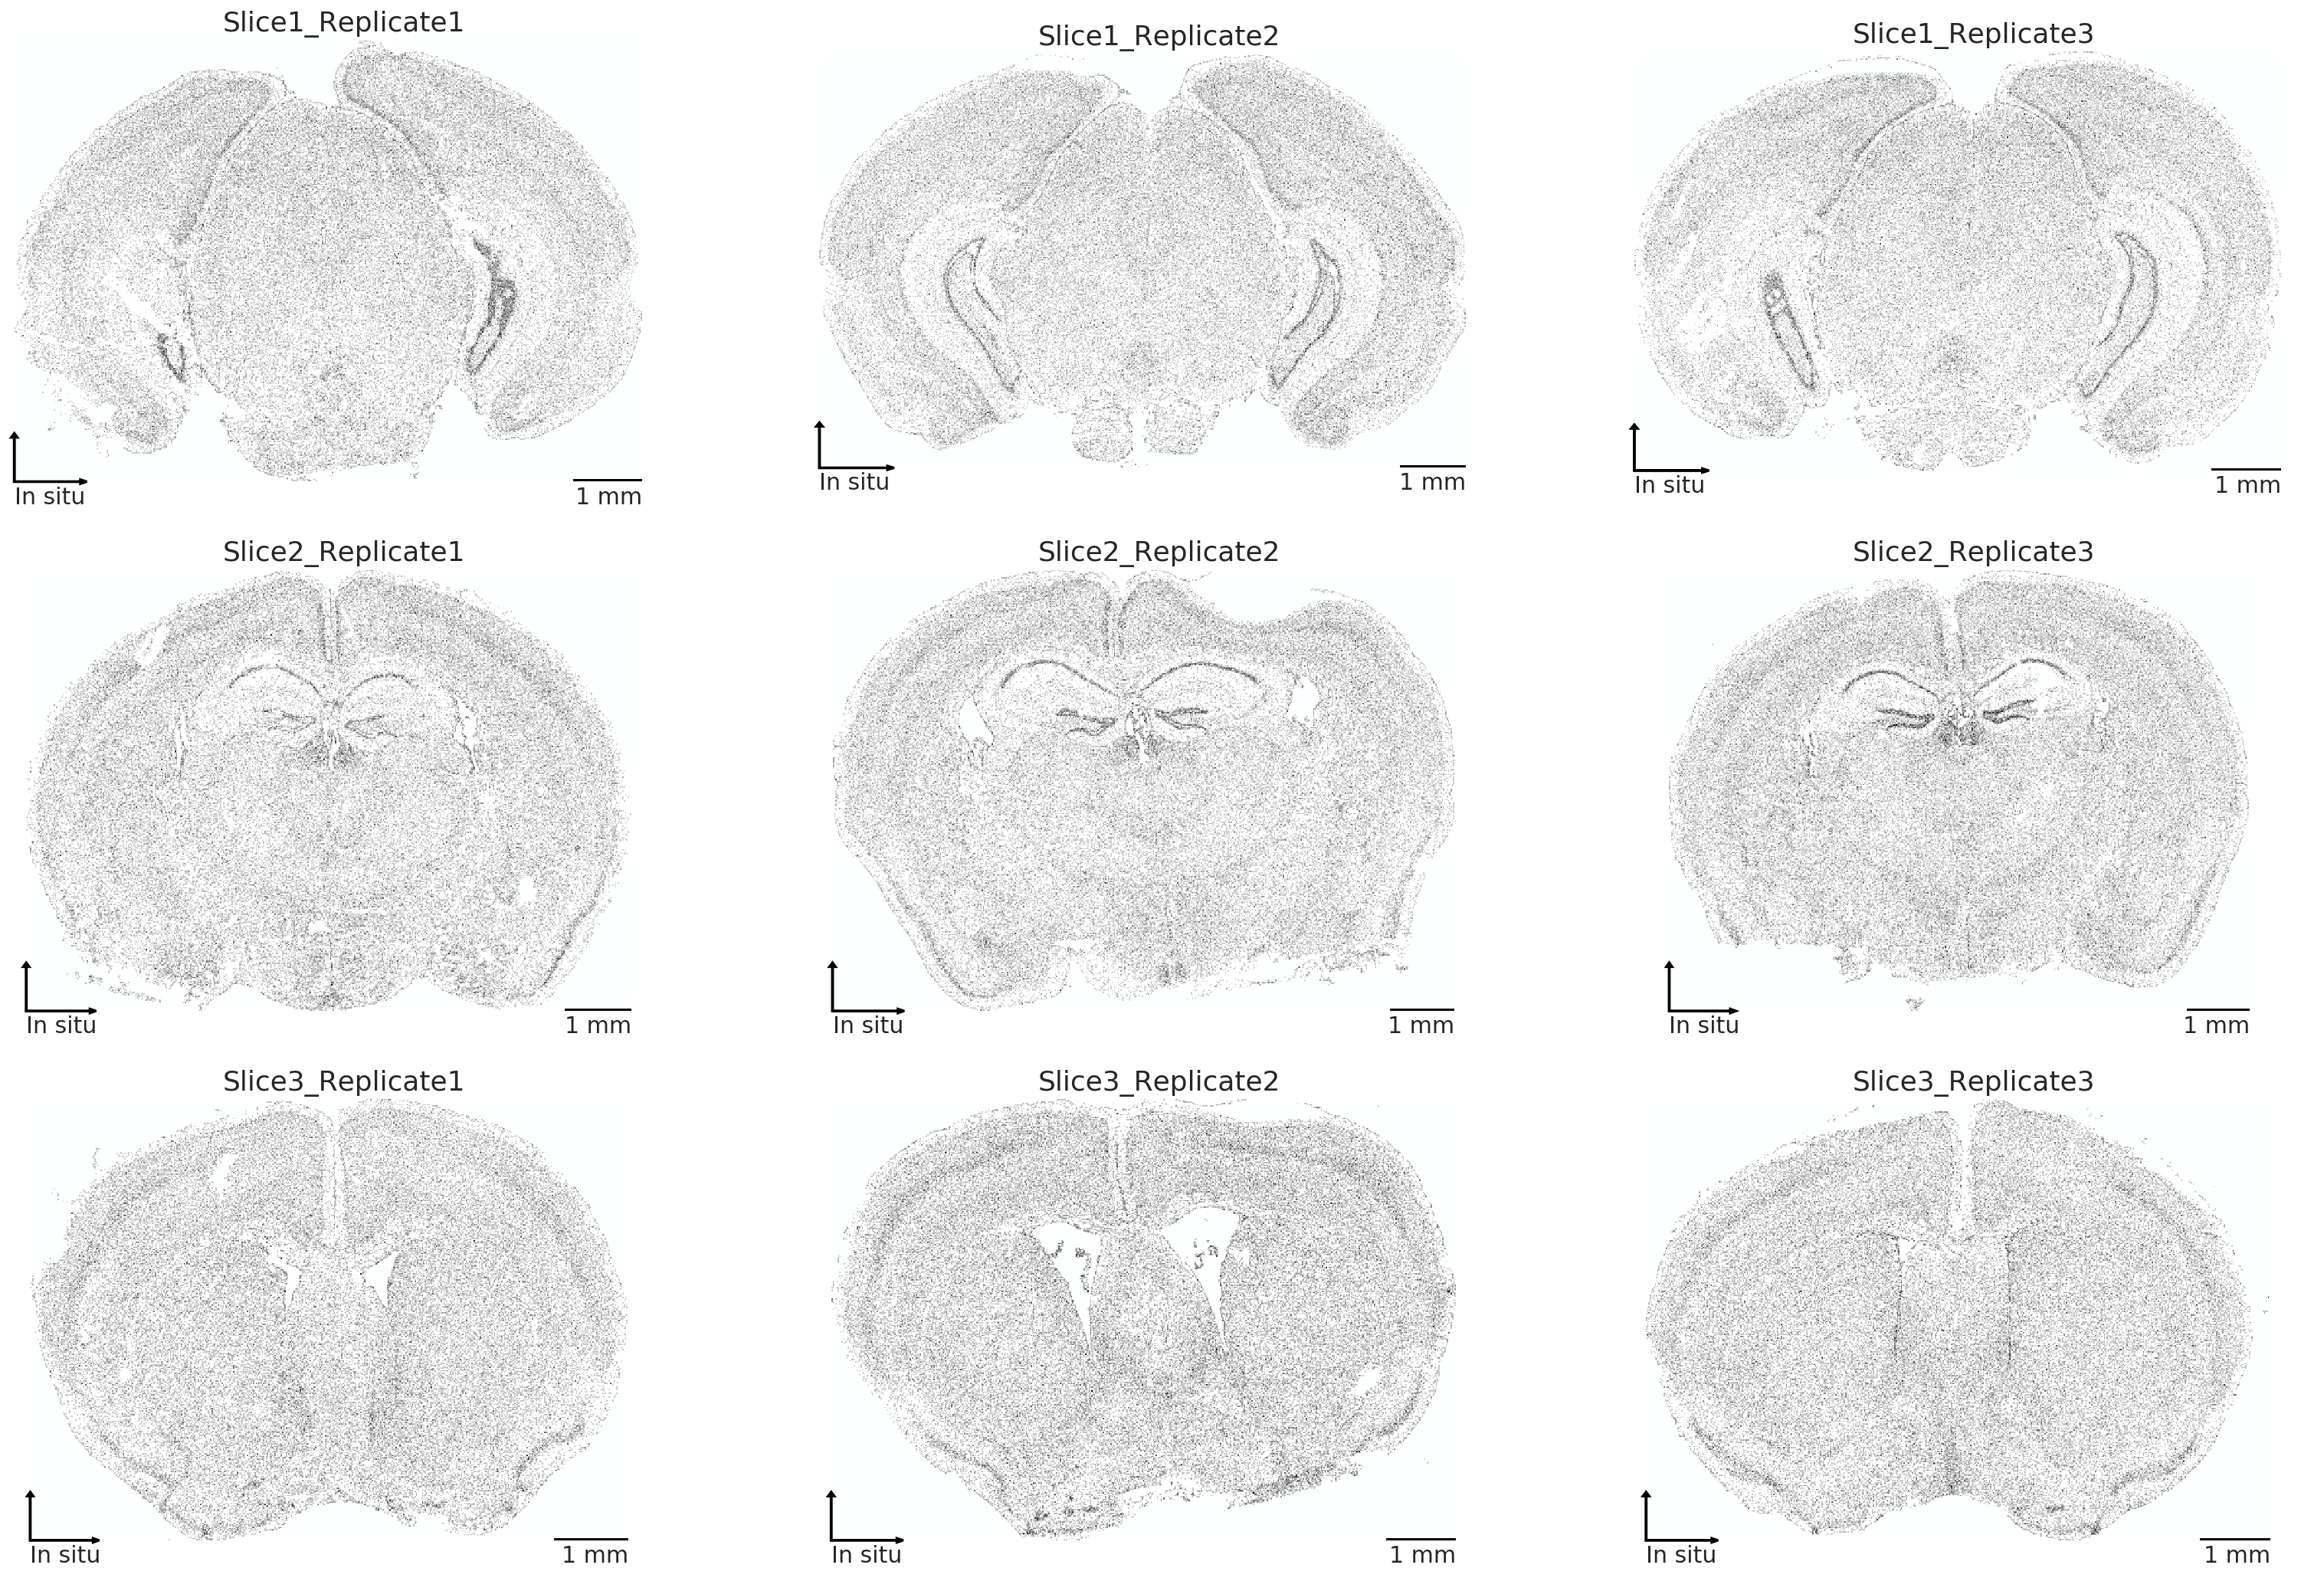

In [17]:

x, y = 'x', 'y'
agg = ds.count()
# agg = ds.mean('volume')
scale_paras = dict(
#        npxlx=500,
    npxly=350, 
#         pxl_scale=20,
)
cmap = colorcet.cm.gray_r
# cmap = ['white', 'black']
# cmap = colorcet.cm.fire

fig, axs = plt.subplots(3, 3, figsize=(9*3,6*3))
for ax, sample in zip(axs.flat, samples):
    data = thedata[thedata['sample']==sample]
    title = sample
    plot_insitu_routine(ax, data, x, y, agg, scale_paras, cmap, title)
    
plt.show()

## Todo - visualization solutions

- plot continuous (genes)
- plot categorical (one-by-one)
- plot categorical (deep downsampling)

- other cmap?
- try cellxgene???

## visualize each cluster (downsample)

In [18]:
# subsamp

nsample = 20000
toplot_subsamp = thedata.sample(n=nsample)

print(toplot_subsamp.shape)
toplot_subsamp.head()

(20000, 17)


cluster    umap_1    umap_2  \
cell                                                                  
169036482191311812221715311397046672944     C28 -9.477338  1.739270   
182948827247518369818545193825060000415      C4  0.960278  5.573706   
333500431553977639006881989225419757844      C4  0.906371  4.895080   
259880986246652897513198243106153759010      C2 -7.329021 -1.036547   
179449447753831990006693352913149014562      C5  2.995220 -5.536345   

                                                   x            y   fov  \
cell                                                                      
169036482191311812221715311397046672944 -3130.724185 -2023.478293  1052   
182948827247518369818545193825060000415  1925.125597  2656.080628    48   
333500431553977639006881989225419757844 -2748.710155 -2555.761092  1511   
259880986246652897513198243106153759010 -2617.698241  1069.813935   691   
179449447753831990006693352913149014562   509.681051 -1712.085763   569   

                                              volume     center_x  \
cell                                                                
169036482191311812221715311397046672944  1038.157057  7746.365992   
182948827247518369818545193825060000415   940.008691   631.043974   
333500431553977639006881989225419757844   570.449411  8165.495282   
259880986246652897513198243106153759010  1383.125706  4501.332053   
179449447753831990006693352913149014562   401.180152  4023.400753   

                                            center_y        min_x  \
cell                                                                
169036482191311812221715311397046672944  5244.760564  7739.011191   
182948827247518369818545193825060000415  4294.241940   624.553174   
333500431553977639006881989225419757844  3960.731586  8161.002482   
259880986246652897513198243106153759010  1435.158061  4494.193253   
179449447753831990006693352913149014562  5080.806213  4017.665953   

                                               max_x        min_y  \
cell                                                                
169036482191311812221715311397046672944  7753.720792  5238.053764   
182948827247518369818545193825060000415   637.534775  4285.861140   
333500431553977639006881989225419757844  8169.988082  3954.294786   
259880986246652897513198243106153759010  4508.470854  1427.425261   
179449447753831990006693352913149014562  4029.135553  5076.745413   

                                               max_y  cell_cov  cell_cov_norm  \
cell                                                                            
169036482191311812221715311397046672944  5251.467364     575.0     456.676799   
182948827247518369818545193825060000415  4302.622740     306.0     276.515546   
333500431553977639006881989225419757844  3967.168387     202.0     243.098525   
259880986246652897513198243106153759010  1442.890862     823.0     505.438334   
179449447753831990006693352913149014562  5084.867013     224.0     489.136804   

                                                    sample cluster_cat  
cell                                                                    
169036482191311812221715311397046672944  Slice1_Replicate1         C28  
182948827247518369818545193825060000415  Slice3_Replicate1          C4  
333500431553977639006881989225419757844  Slice1_Replicate2          C4  
259880986246652897513198243106153759010  Slice3_Replicate1          C2  
179449447753831990006693352913149014562  Slice3_Replicate2          C5

In [ ]:
x_spatial, y_spatial = 'x', 'y'
x_umap, y_umap = 'umap_1', 'umap_2'
hue = 'cluster'
legend = False
fontsize = 12

# n = len(uniq_clsts)
for i, clst in enumerate(uniq_clsts):
    output1 = figures.format('in_situ_umap_by_clusters_{}_{}.pdf'.format(sample, clst))
    output2 = figures.format('in_situ_umap_by_clusters_{}_{}.png'.format(sample, clst))
    
    fig, axs_row = plt.subplots(1, 2, figsize=(5*2,4*1))
    title = '{}'.format(clst)
    palette_specific = {_clst: palette_clsts[_clst] if _clst == clst else "lightgray" 
                        for _clst in uniq_clsts} 
    ax = axs_row[0]
    plot_spatial_routine(
        ax, x_spatial, y_spatial, hue, toplot, 
        palette_specific, legend=legend, title=title, fontsize=fontsize,
    )
    ax = axs_row[1]
    plot_umap_routine(
        ax, x_umap, y_umap, hue, toplot, 
        palette_specific, legend=legend, title='', fontsize=fontsize,
    )
    fig.subplots_adjust(wspace=-0.2)
    
    for output in [output1, output2]:
        print(output)
        snmcseq_utils.savefig(fig, output)
    plt.show()
    break

## hippocampus cell types and genes
- C19,21
- DKL1, DRD1, DRD2, FN1, HTR2C, TRHR

In [ ]:
curated_genes = snmcseq_utils.read_googlesheet('curated_gene_list', 'genes_organized')
print(curated_genes.shape)
curated_genes = curated_genes[curated_genes['gene_name']!='']
print(curated_genes.shape)
overlaped_genes = np.intersect1d(curated_genes['gene_name'], genes.map(lambda x: x.upper()))
curated_genes = curated_genes[curated_genes['gene_name'].isin(overlaped_genes)]
print(curated_genes.shape)

curated_genes_list = curated_genes['gene_name'].apply(lambda x: x[0]+x[1:].lower()).values

curated_genes

In [ ]:
curated_genes_list

### visualize the expression of these 6 genes across all slices

<!-- ![](../figures/2021-05-01_Fn1.png)
![](../figures/2021-05-01_Dlk1.png)
![](../figures/2021-05-01_Htr2c.png)
![](../figures/2021-05-01_Trhr.png)
![](../figures/2021-05-01_Drd1.png)
![](../figures/2021-05-01_Drd2.png) -->

## ANOVA genes

In [ ]:
ti = time.time()
tss_df = utils.anova_analysis(gmat, clsts.reindex(gmat.index)['cluster'])
tss_df['s2/mu']  = tss_df['s2']/tss_df['mu']
print(time.time()-ti)
print(tss_df.shape)
tss_df.head()

In [ ]:
selected_group = ['C19', 'C21',]
delta = np.log2( 
    gmat.loc[clsts[clsts['cluster'].isin(selected_group)].index].mean()
   /gmat.loc[clsts[~clsts['cluster'].isin(selected_group)].index].mean()
    )
tss_df['delta'] = delta 

In [ ]:
# 
for col in tss_df:
    fig, ax = plt.subplots(figsize=(6,1))
    sns.boxplot(tss_df[col], ax=ax)
    sns.despine(ax=ax)
    plt.show()

In [ ]:
x, y, pdata = 'mu', 's2', tss_df
xmin, xmax = pdata[x].min(), pdata[x].max()
ymin, ymax = pdata[y].min(), pdata[y].max()
xmin, xmax = -0.05*xmax, 1.1*xmax
ymin, ymax = -0.05*ymax, 1.1*ymax

fig, ax = plt.subplots()
sns.scatterplot(x=x, y=y, data=pdata, ax=ax,)

ax.axvline(pdata[x].median(), color='k', linestyle='--', label='median')
ax.axhline(pdata[y].median(), color='k', linestyle='--', label='median')
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
sns.despine(ax=ax)
plt.show()

In [ ]:
x, y, pdata = 'mu', 's2/mu', tss_df
xmin, xmax = pdata[x].min(), pdata[x].max()
ymin, ymax = pdata[y].min(), pdata[y].max()
xmin, xmax = -0.05*xmax, 1.1*xmax
ymin, ymax = -0.05*ymax, 1.1*ymax

fig, ax = plt.subplots()
sns.scatterplot(x=x, y=y, data=pdata, ax=ax,)
ax.axvline(pdata[x].median(), color='k', linestyle='--', label='median')
ax.axhline(pdata[y].median(), color='k', linestyle='--', label='median')
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
sns.despine(ax=ax)
plt.show()

In [ ]:
x, y, pdata = 'eta2', 's2/mu', tss_df
xmin, xmax = pdata[x].min(), pdata[x].max()
ymin, ymax = pdata[y].min(), pdata[y].max()
xmin, xmax = -0.05*xmax, 1.1*xmax
ymin, ymax = -0.05*ymax, 1.1*ymax

fig, ax = plt.subplots()
sns.scatterplot(x=x, y=y, data=pdata, ax=ax,)
ax.axvline(pdata[x].median(), color='k', linestyle='--', label='median')
ax.axhline(pdata[y].median(), color='k', linestyle='--', label='median')
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
sns.despine(ax=ax)
plt.show()

In [ ]:
xs = ['mu', 's2', 's2/mu', 'eta2']
percentile_th = 90
for x in xs:
    x, y, pdata = x, 'delta', tss_df
    xmin, xmax = pdata[x].min(), pdata[x].max()
    ymin, ymax = pdata[y].min(), pdata[y].max()
    xmin, xmax = -0.05*xmax, 1.1*xmax
    ymin, ymax = -10, 1.2*ymax

    fig, ax = plt.subplots()
    sns.scatterplot(x=x, y=y, data=pdata, ax=ax,)
    ax.axvline(pdata[x].median(), color='k', linestyle='--', label='median')
#     ax.axvline(np.percentile(pdata[x], percentile_th), color='C1', linestyle='--', label='{}%'.format(percentile_th))
    ax.axhline(pdata[y].median(), color='k', linestyle='--', label='median')
    ax.axhline(np.percentile(pdata[y], percentile_th), color='C1', linestyle='--', label='{}%'.format(percentile_th))
    
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    
    ax.set_ylabel('log2(FC)\n(hippo. vs. non-hippo.)')
    sns.despine(ax=ax)
    plt.show()

In [ ]:
layers = [0,1,2]

percentile_th = 90
x, y, pdata = 'eta2', 'delta', tss_df
xmin, xmax = pdata[x].min(), pdata[x].max()
ymin, ymax = pdata[y].min(), pdata[y].max()
xmin, xmax = -0.05*xmax, 1.1*xmax
ymin, ymax = -10, 1.2*ymax


for layer in layers:
    fig, ax = plt.subplots()
    
    color = 'gray'
    if layer > 0:
        color = 'lightgray'
        
    sns.scatterplot(x=x, y=y, data=pdata, ax=ax, color=color, edgecolor='none', s=50)
    ax.axvline(pdata[x].median(), color='k', linestyle='--', label='median')
    ax.axhline(pdata[y].median(), color='k', linestyle='--', label='median')

    if layer == 1:
        cutoffy = np.percentile(pdata[y], percentile_th)
        cutoffx = np.percentile(pdata[x], 50)
        ax.axhline(cutoffy, color='k', linestyle='dotted', label='{}%'.format(percentile_th))
        pdata_selected = pdata[((pdata[y]>cutoffy) & (pdata[x]>cutoffx))]
        sns.scatterplot(x=x, y=y, data=pdata_selected, ax=ax, color='C1', zorder=2, edgecolor='none')
        ax.set_title('{} genes selected'.format(len(pdata_selected)))
    if layer == 2:
        pdata_curated = pdata.loc[curated_genes_list]
        sns.scatterplot(x=x, y=y, data=pdata_curated, ax=ax, color='C3', zorder=2, edgecolor='none')
        ax.set_title('{} curated genes'.format(len(pdata_curated)))
        for gene_name, row in pdata_curated.iterrows():
            ax.text(row[x], row[y], gene_name)
        
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')

    ax.set_xlabel('eta2\n(Overall cell type specificity)')
    ax.set_ylabel('log2(FC)\n(hippo. vs. non-hippo.)')
    sns.despine(ax=ax)
    plt.show()

In [ ]:
prioritized_genes = np.sort(pdata_selected.index.values)
print(prioritized_genes)

In [ ]:
np.intersect1d(curated_genes_list, prioritized_genes)

## Visualize genes
- boxplot + UMAP + spatial

In [ ]:
curated_genes_list

In [ ]:
# gene_list = np.hstack([prioritized_genes, curated_genes_list])

toplot = thedata.join(gmat)

gene_list = ['Epha7', 'Epha8', 'Gpr161', 'Trhr']
for gene in gene_list:
    palette_specific = {_clst: palette_clsts[_clst] if _clst in selected_group else "lightgray" 
                            for _clst in uniq_clsts} 
    x_spatial, y_spatial = 'x', 'y'
    x_umap, y_umap = 'umap_1', 'umap_2'
    hue = gene
    fontsize = 12
    x_box, y_box = 'cluster', gene
    vmaxp = 95
    pth = 90
    
    fig = plt.figure(figsize=(12,12))
    specs = gridspec.GridSpec(nrows=3, ncols=3)
    
    # in-situ
    ax = fig.add_subplot(specs[:2,:2])  
    title = gene
    plot_continuous_spatial_routine(
        ax, x_spatial, y_spatial, hue, toplot, 
        vmaxp=vmaxp,
        title=title, fontsize=fontsize,
    )
    
    # UMAP 
    ax = fig.add_subplot(specs[:2,2])  
    plot_continuous_umap_routine(
        ax, x_umap, y_umap, hue, toplot, 
        vmaxp=vmaxp,
        title='', fontsize=fontsize,
        pth=pth,
    )
    
    # boxplot
    ax = fig.add_subplot(specs[2,:])  
    sns.boxplot(x=x_box, y=y_box, data=toplot, 
                ax=ax, 
                palette=palette_specific, 
                order=np.sort(toplot[x_box].unique()),
               )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    sns.despine(ax=ax)
    
    fig.subplots_adjust(wspace=0, hspace=-0.1)
    
    output1 = figures.format('gene_view_{}_{}.pdf'.format(sample, gene))
    output2 = figures.format('gene_view_{}_{}.png'.format(sample, gene))
    for output in [output1, output2]:
        print(output)
        snmcseq_utils.savefig(fig, output)
    plt.show()
    

In [ ]:
# group cell level into clsuter level
gmat_group = gmat.join(clsts['cluster']).groupby('cluster').mean()
# zscore per gene
gmat_group = (gmat_group - gmat_group.mean())/gmat_group.std()

In [ ]:

heatmap = gmat_group[np.hstack([prioritized_genes, curated_genes_list])].T

cols = heatmap.columns
cols = np.hstack([selected_group, cols.drop(selected_group)])
heatmap = heatmap[cols]

cbar_kws = DEFAULT_COLORBAR_KWS.copy()
cbar_kws['label'] = 'zscore per gene\n(mean over cells per cluster)'

fig, ax = plt.subplots(figsize=(12, 13))
sns.heatmap(heatmap, ax=ax, cbar_kws=cbar_kws)
ax.axhline(len(prioritized_genes), color='white')
ax.axvline(len(selected_group), color='white')
plt.show()

# Genes

In [ ]:
genes

In [ ]:
print(np.sort(genes).tolist())

In [ ]:
client = snmcseq_utils.setup_googlesheet()
df = snmcseq_utils.read_googlesheet('Zhang_Keown_Mukamel_Meaney', 'Differential Expression')
df = pd.DataFrame(df.loc[2:].iloc[:,:7].values, columns=df.loc[1].iloc[:7]).groupby('Gene').first().drop('ID', axis=1)
df = df.astype(np.float64)
print(df.shape)
df.head()

In [ ]:
df_up = df[((df['QValuedDG']<0.05) & (df['logFCdDG_in_SH']>0))].sort_values('QValuedDG')
df_down = df[((df['QValuedDG']<0.05) & (df['logFCdDG_in_SH']<0))].sort_values('QValuedDG')
print(df_up.shape, df_down.shape)

In [ ]:
upgenes = np.intersect1d(genes, df_up.index.values)
print(upgenes.shape)
upgenes

In [ ]:
downgenes = np.intersect1d(genes, df_down.index.values)
print(downgenes.shape)
downgenes